In [1]:
%matplotlib widget

import torch
import os
os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

from typing import Union, List
from diffSPH.kernels import getKernel
from diffSPH.v2.sphOps import sphOperation
from diffSPH.v2.math import volumeToSupport

from diffSPH.v2.math import mod
# from torchCompactRadius import radiusSearch
# from torchCompactRadius.util import countUniqueEntries

from diffSPH.v2.sampling import sampleRegular
# from torchCompactRadius import radiusSearch
# from torchCompactRadius.util import countUniqueEntries
from diffSPH.v2.sphOps import sphOperation
from diffSPH.v2.math import mod, volumeToSupport
from diffSPH.kernels import getKernel
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.sampling import samplePDF
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.shifting import computeShifting
import numpy as np
import torch

from diffSPH.v2.finiteDifference import computeGradient
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

# def scatterPlot(fig, axis, p, c, domainMin, domainMax, label = None, periodic = True):
#     pos = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - domainMin[i], domainMax[i] - domainMin[i]) + domainMin[i] for i in range(dim)], dim = 1)
#     sc = axis.scatter(pos[:,0], pos[:,1], s = 8, c = c)
#     ax1_divider = make_axes_locatable(axis)
#     cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
#     cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
#     if label is not None:
#         axis.set_title(label)
#     if p.shape[1] > 1:
#         square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
#         axis.add_patch(square)
#     axis.set_aspect('equal')
#     axis.set_xlim(domainMin[0] * 1.05, domainMax[0] * 1.05)
#     axis.set_ylim(domainMin[1] * 1.05, domainMax[1] * 1.05)

# def scatterPlotSymmetric(fig, axis, p, c, domainMin, domainMax, label = None, periodic = True):
#     pos_x = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - domainMin[i], domainMax[i] - domainMin[i]) + domainMin[i] for i in range(dim)], dim = 1)
#     # pos_y = torch.stack([y[:,i] if not periodic_i else torch.remainder(y[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic_i in enumerate(periodicity)], dim = 1)

#     sc = axis.scatter(pos_x[:,0], pos_x[:,1], s = 8, c = c, vmin = -c.abs().max(), vmax = c.abs().max(), cmap = 'Spectral')
#     ax1_divider = make_axes_locatable(axis)
#     cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
#     cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
#     if label is not None:
#         axis.set_title(label)
#     if p.shape[1] > 1:
#         square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
#         axis.add_patch(square)
#     axis.set_aspect('equal')
#     axis.set_xlim(-1.05,1.05)
#     axis.set_ylim(-1.05,1.05)

In [43]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.sphOps import sphOperationStates
from diffSPH.v2.util import countUniqueEntries
from diffSPH.v2.plotting import plotImplicitSDF
from diffSPH.v2.modules.surfaceDetection import computeColorField, computeColorFieldGradient
from diffSPH.v2.modules.surfaceDetection import detectFreeSurfaceColorFieldGradient
import matplotlib.pyplot as plt
import torch
import numpy as np
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

config = {
    'domain': {
        'minExtent': -1,
        'maxExtent': 1,
        'dim': 2,
        'periodic': True
    },
    'particle': {
        'nx': 128
    },
    'kernel':{
        'name': 'Wendland2',
    'targetNeighbors': 45.22,
    },
    "neighborhood":{
        "scheme": "compact"
    },
    'EOS':{
        'type': 'Tait',
        'kappa': 1.5
    },
    'shifting':{
        'freeSurface': True
    }
}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)

display(config)

{'domain': {'minExtent': tensor([-1., -1.]),
  'maxExtent': tensor([1., 1.]),
  'dim': 2,
  'periodic': True,
  'periodicity': tensor([True, True])},
 'particle': {'nx': 128,
  'dx': tensor(0.0156),
  'kernelScale': tensor(1.8970),
  'defaultVolume': tensor(0.0002),
  'defaultSupport': 0.05928029670513617,
  'volume': tensor(0.0002),
  'support': 0.05928029670513617,
  'smoothingLength': tensor(0.0312)},
 'kernel': {'name': 'Wendland2',
  'targetNeighbors': 45.22,
  'function': <diffSPH.kernels.KernelWrapper at 0x7e369515d410>,
  'kernelScale': tensor(1.8970)},
 'neighborhood': {'scheme': 'compact', 'verletScale': 1.5},
 'EOS': {'type': 'Tait',
  'kappa': 1.5,
  'gasConstant': 8.14,
  'molarMass': 0.02897,
  'polytropicExponent': 7},
 'shifting': {'freeSurface': True,
  'scheme': 'deltaSPH',
  'R': 0.25,
  'n': 4,
  'CFL': 1.5,
  'computeMach': True,
  'solver': 'BiCGStab_wJacobi',
  'normalScheme': 'lambda',
  'projectionScheme': 'mat',
  'threshold': 0.5,
  'surfaceScaling': 0.1,
  '

In [44]:
from diffSPH.v2.plotting import *

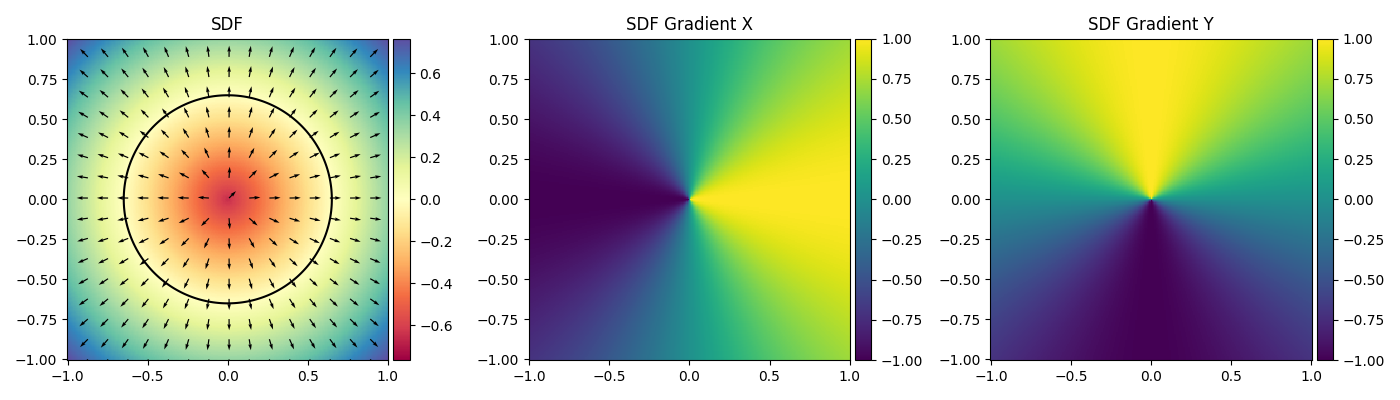

In [45]:
ngrid = 255
x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('hexagon')['function'](points, 0.5)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([0.5,0.5]))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)
sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)
sdf = sphere_b

# sdf = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.65), torch.tensor([-0.,0.]))
sdf = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.65), torch.tensor([ 0.,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)

plotImplicitSDF(sdf, ngrid = 255, minExtent = -1, maxExtent = 1)

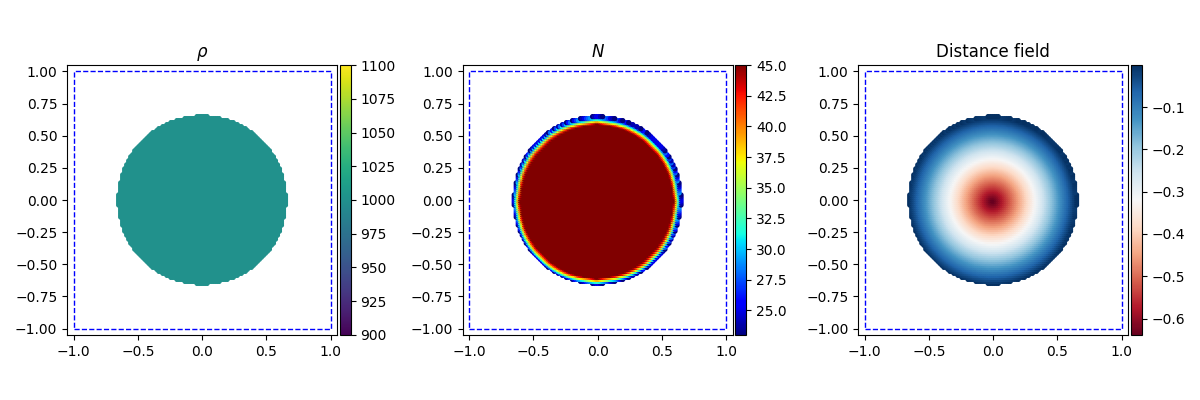

In [46]:
from diffSPH.v2.sampling import sampleParticles
import copy
fluidState, mask = sampleParticles(config, sdfs = [sdf])
particleState = {'fluid': fluidState, 'time': 0.0, 'timestep': 0, 'dt': config['timestep']['dt']}
initialState = copy.deepcopy(particleState)

# for k in particleState.keys():
    # if isinstance(particleState['fluid'][k], torch.Tensor):
        # particleState[k] = particleState[k][mask]
particleState['numParticles'] = particleState['fluid']['positions'].shape[0]
initialPositions = torch.clone(particleState['fluid']['positions'])

fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['densities'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['numNeighbors'], config['domain']['minExtent'], config['domain']['maxExtent'], '$N$', cmap = 'jet', s = 8)
scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], particleState['fluid']['distances'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Distance field', cmap = 'RdBu', s = 8)

fig.tight_layout()

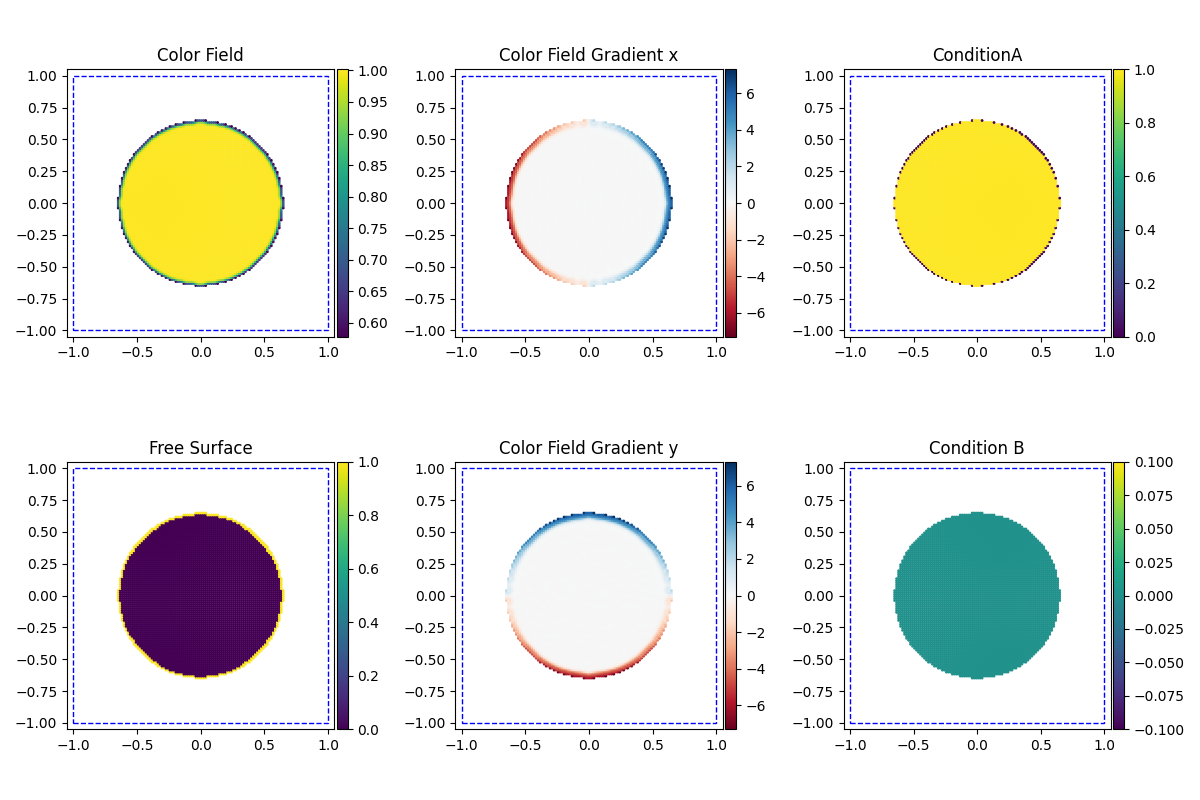

In [47]:
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne, expandFreeSurfaceMask, computeColorField, detectFreeSurfaceBarecasco, computeColorFieldGradient, detectFreeSurfaceColorFieldGradient
from diffSPH.v2.modules.shifting import computeLambdaGrad, deltaPlusShifting, computeShifting, BiCGStab_wJacobi, BiCG, LinearCG, BiCGStab

particleState['fluid']['densities'] = torch.ones_like(particleState['fluid']['areas']) * ( config['fluid']['rho0'])
# particleState['fluid']['densities'] = sphOperationFluidState(particleState, None, 'density')

particleState['fluid']['color'] = computeColorField(particleState['fluid'], particleState['fluid'], particleState['fluid']['neighborhood'], config)
# particleState['fluid']['densities'][:] = config['fluid']['rho0']
particleState['fluid']['colorGradient'] = computeColorFieldGradient(particleState['fluid'], particleState['fluid'], particleState['fluid']['neighborhood'], config)
config['surfaceDetection']['colorFieldGradientThreshold'] = 10.0
fs = detectFreeSurfaceColorFieldGradient(particleState['fluid'], particleState['fluid'], particleState['fluid']['neighborhood'], config)
particleState['fluid']['L'], normalizationMatrices, particleState['fluid']['L.EVs'] = computeNormalizationMatrices(particleState['fluid'], particleState['fluid'], particleState['fluid']['neighborhood'], config)
particleState['fluid']['normals'], particleState['fluid']['Lambdas'] = computeNormalsMaronne(particleState['fluid'], particleState['fluid'], particleState['fluid']['neighborhood'], config)
particleState['fluid']['freeSurface'], cA, cB = detectFreeSurfaceMaronne(particleState['fluid'], particleState['fluid'], particleState['fluid']['neighborhood'], config)
particleState['fluid']['freeSurface'] = detectFreeSurfaceBarecasco(particleState['fluid'], particleState['fluid'], particleState['fluid']['neighborhood'], config)
particleState['fluid']['freeSurfaceMask'] = expandFreeSurfaceMask(particleState['fluid'], particleState['fluid'], particleState['fluid']['neighborhood'], config)
# particleState['fluid']['freeSurface'] = particleState['fluid']['Lambdas'] < 0.4

fig, axis = plt.subplots(2, 3, figsize=(12, 8), sharex = False, sharey = False, squeeze = False)

scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['color'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Color Field', cmap = 'viridis', s = 1)
scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['colorGradient'][:,0], config['domain']['minExtent'], config['domain']['maxExtent'], 'Color Field Gradient x', cmap = 'RdBu', s = 1)
scatterPlot(fig, axis[1,1], particleState['fluid']['positions'], particleState['fluid']['colorGradient'][:,1], config['domain']['minExtent'], config['domain']['maxExtent'], 'Color Field Gradient y', cmap = 'RdBu', s = 1)
scatterPlot(fig, axis[1,0], particleState['fluid']['positions'], particleState['fluid']['freeSurface'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Free Surface', cmap = 'viridis', s = 1)

scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], cA, config['domain']['minExtent'], config['domain']['maxExtent'], 'ConditionA', cmap = 'viridis', s = 1)
scatterPlot(fig, axis[1,2], particleState['fluid']['positions'], cB, config['domain']['minExtent'], config['domain']['maxExtent'], 'Condition B', cmap = 'viridis', s = 1)

fig.tight_layout()

In [49]:
# from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
# from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne, expandFreeSurfaceMask


In [50]:


# particleState['fluid']['L'], normalizationMatrices, particleState['L.EVs'] = computeNormalizationMatrices(particleState, config)
# particleState['fluid']['normals'], lMin = computeNormalsMaronne(particleState, config)
# particleState['fluid']['freeSurface'], cA, cB = detectFreeSurfaceMaronne(particleState, config)
# particleState['fluid']['freeSurfaceMask'] = expandFreeSurfaceMask(particleState, config)

# fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
# scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['freeSurfaceMask'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Surface mask', cmap = 'viridis', s = 8)
# scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['normals'][:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$N.x$', cmap = 'RdBu', s = 8)
# scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], particleState['fluid']['normals'][:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$N.y$', cmap = 'RdBu', s = 8)
# fig.tight_layout()


In [51]:
from diffSPH.v2.shifting import BiCGStab, LinearCG, evalKernel


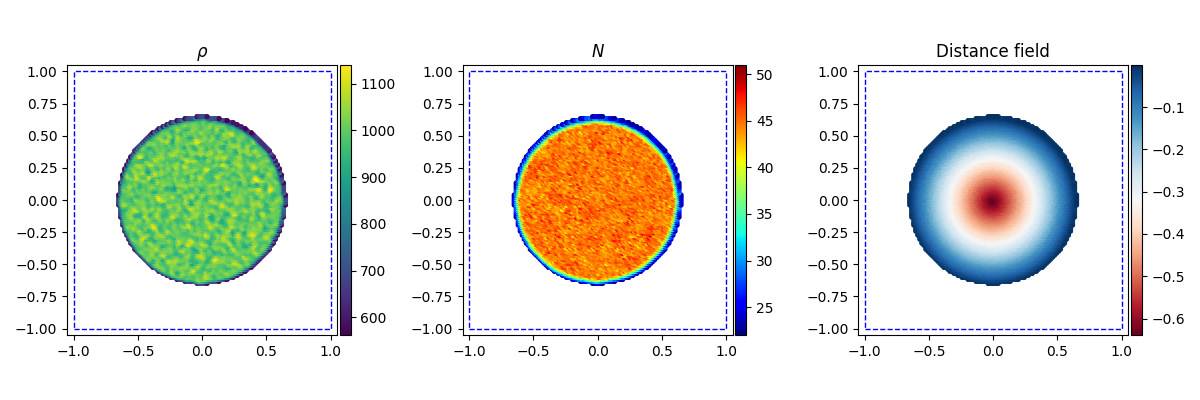

In [52]:

particleState['fluid']['positions'] = initialPositions.clone() 
jitter = torch.rand(particleState['fluid']['positions'].shape) * config['particle']['dx'] - config['particle']['dx'] * 0.5
jitter = jitter *  torch.clamp(torch.abs(particleState['fluid']['distances'][:,None]) / config['particle']['support'], 0, 1)


particleState['fluid']['positions'] += jitter * 0.5

_, particleState['fluid']['neighborhood'] = neighborSearch(particleState['fluid'], particleState['fluid'], config)
particleState['fluid']['densities'] = sphOperationStates(particleState['fluid'],particleState['fluid'], quantities = None, operation = 'density', neighborhood = particleState['fluid']['neighborhood'])
_, particleState['fluid']['numNeighbors'] = countUniqueEntries(particleState['fluid']['neighborhood']['indices'][0], particleState['fluid']['positions'])

fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['densities'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['numNeighbors'], config['domain']['minExtent'], config['domain']['maxExtent'], '$N$', cmap = 'jet', s = 8)
scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], particleState['fluid']['distances'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Distance field', cmap = 'RdBu', s = 8)

fig.tight_layout()


BiCGStab Solver
Initial Residual: 373.3489990234375, Threshold 0.0001
atol: 0.03733489990234375 [0.0001]
rhotol: 1.4210854715202004e-14 | omegatol: 1.4210854715202004e-14
Initial Residual: 400.175537109375
	[  0]	Residual: 71.42147827148438 | rho: 160140.453125 | alpha: 0.0004160745593253523 | omega: 0.0003856155090034008
	[  1]	Residual: 26.06549072265625 | rho: 16934.1875 | alpha: 0.0006269364384934306 | omega: 0.0004867513489443809
	[  2]	Residual: 12.341349601745605 | rho: 3587.5595703125 | alpha: 0.0006336214719340205 | omega: 0.00047365535283461213
	[  3]	Residual: 6.951526165008545 | rho: 773.9838256835938 | alpha: 0.0006861932342872024 | omega: 0.00048556053661741316
	[  4]	Residual: 4.219182014465332 | rho: 202.86776733398438 | alpha: 0.0007206197478808463 | omega: 0.00048380871885456145
	[  5]	Residual: 2.6677820682525635 | rho: 58.60758972167969 | alpha: 0.000746124133002013 | omega: 0.0005129495402798057
	[  6]	Residual: 1.7478249073028564 | rho: 18.866849899291992 | alpha:

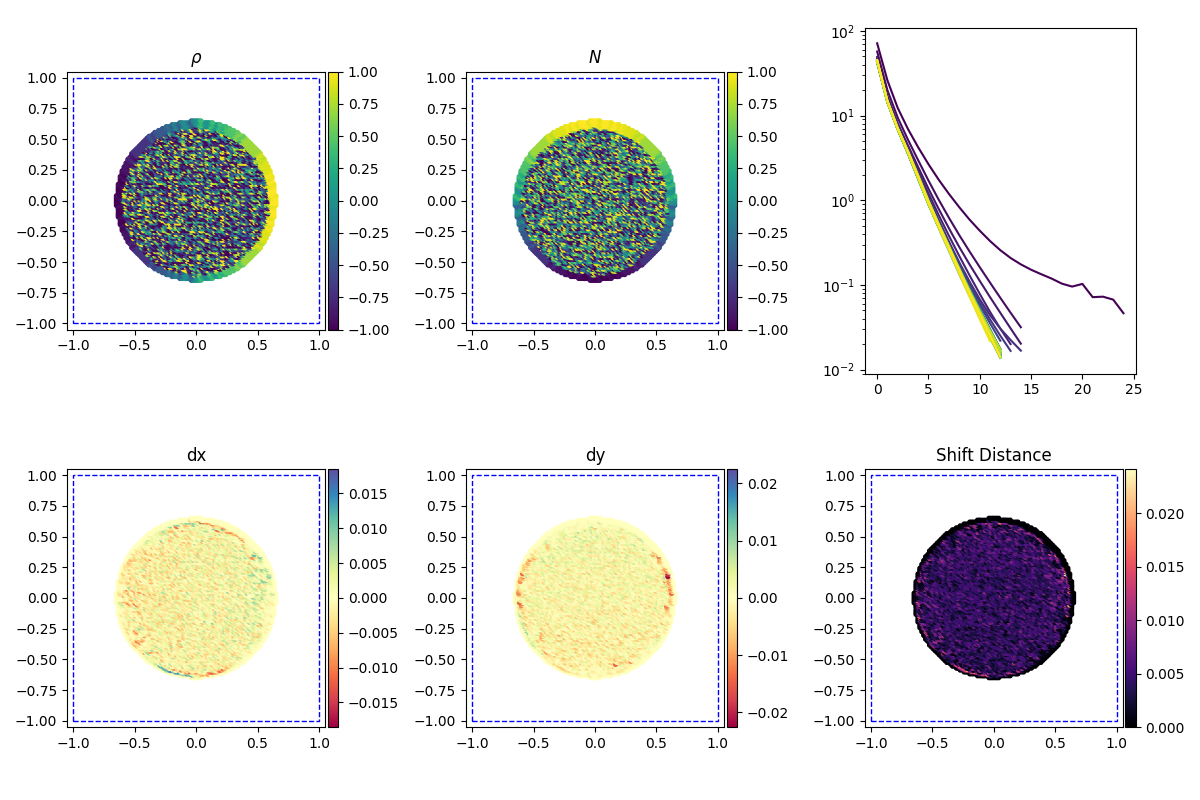

In [53]:
from diffSPH.v2.modules.shifting import solveShifting
config['shifting']['scheme'] = 'IPS'
# config['shifting']['scheme'] = 'delta'
config['shifting']['computeMach'] = False
config['shifting']['maxIterations'] = 32
config['shifting']['solver'] = 'BiCGStab_wJacobi'
config['shifting']['normalScheme'] = 'lambda'
config['shifting']['freeSurface'] = True
config['shifting']['useExtendedMask'] = False
config['shifting']['projectionScheme'] = 'mat'
config['shifting']['surfaceScaling'] = 1.0
config['shifting']['surfaceDetection'] = 'colorGrad'
config['shifting']['summationDensity'] = False
config['shifting']['surfaceDetection'] = 'Maronne'
config['shifting']['surfaceDetection'] = 'Barcasco'
config['shifting']['initialization'] = 'deltaPluss'
config['shifting']['threshold'] = 0.1
config['shifting']['verbose'] = True
config['shifting']['solverThreshold'] = 0.256
config['surfaceDetection']['expansionIterations'] = 2

import matplotlib.colors as mcolors

fig, axis = plt.subplots(2, 3, figsize=(12, 8), sharex = False, sharey = False, squeeze = False)

particleState['fluid']['positions'] = initialPositions.clone() + jitter* 0.75

positions = torch.clone(particleState['fluid']['positions'])
particleState['fluid']['densities'] = torch.ones_like(particleState['fluid']['densities']) * config['fluid']['rho0']

dx, states = solveShifting(particleState, config)
particleState['fluid']['positions'] = particleState['fluid']['positions'] + dx

_, particleState['fluid']['neighborhood'] = neighborSearch(particleState['fluid'], particleState['fluid'], config)
particleState['fluid']['densities'] = sphOperationStates(particleState['fluid'],particleState['fluid'], quantities = None, operation = 'density', neighborhood = particleState['fluid']['neighborhood'])
_, particleState['fluid']['numNeighbors'] = countUniqueEntries(particleState['fluid']['neighborhood']['indices'][0], particleState['fluid']['positions'])

scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['normals'][:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['normals'][:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$N$', cmap = 'viridis', s = 8)
# scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], particleState['fluid']['freeSurface'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Surface Distance', cmap = 'magma', s = 8)

cs = [torch.hstack(s[0]).detach().cpu().numpy() for s in states]
norm = mcolors.Normalize(vmin=0, vmax=len(cs) - 1)
mappable = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
for i in range(len(cs)):
    axis[0,2].plot(cs[i], label = f'iter {i}', c = mappable.to_rgba(i))

axis[0,2].set_yscale('log')

scatterPlotSymmetric(fig, axis[1,0], particleState['fluid']['positions'], dx[:,0], config['domain']['minExtent'], config['domain']['maxExtent'], 'dx', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[1,1], particleState['fluid']['positions'], dx[:,1], config['domain']['minExtent'], config['domain']['maxExtent'], 'dy', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,2], positions, torch.linalg.norm(dx, dim = -1), config['domain']['minExtent'], config['domain']['maxExtent'], 'Shift Distance', cmap = 'magma', s = 8)

# for ax in axis.flatten():
#     ax.axvline(-0.5, c = 'k', ls = '--')
#     ax.axvline(0.5, c = 'k', ls = '--')
#     ax.axhline(-0.5, c = 'k', ls = '--')
#     ax.axhline(0.5, c = 'k', ls = '--')
    
fig.tight_layout()

In [14]:
config['shifting']

{'freeSurface': True,
 'scheme': 'IPS',
 'R': 0.25,
 'n': 4,
 'CFL': 1.5,
 'computeMach': False,
 'solver': 'BiCGStab_wJacobi',
 'normalScheme': 'lambda',
 'projectionScheme': 'mat',
 'threshold': 0.05,
 'surfaceScaling': 1.0,
 'maxIterations': 32,
 'summationDensity': False,
 'useExtendedMask': False,
 'initialization': 'zero',
 'maxSolveIter': 64,
 'surfaceDetection': 'Barcasco',
 'active': True,
 'tol': 0.0001,
 'rtol': 0.0001,
 'preconditioner': 'Jacobi',
 'verbose': False,
 'solverThreshold': tensor(0.0156)}

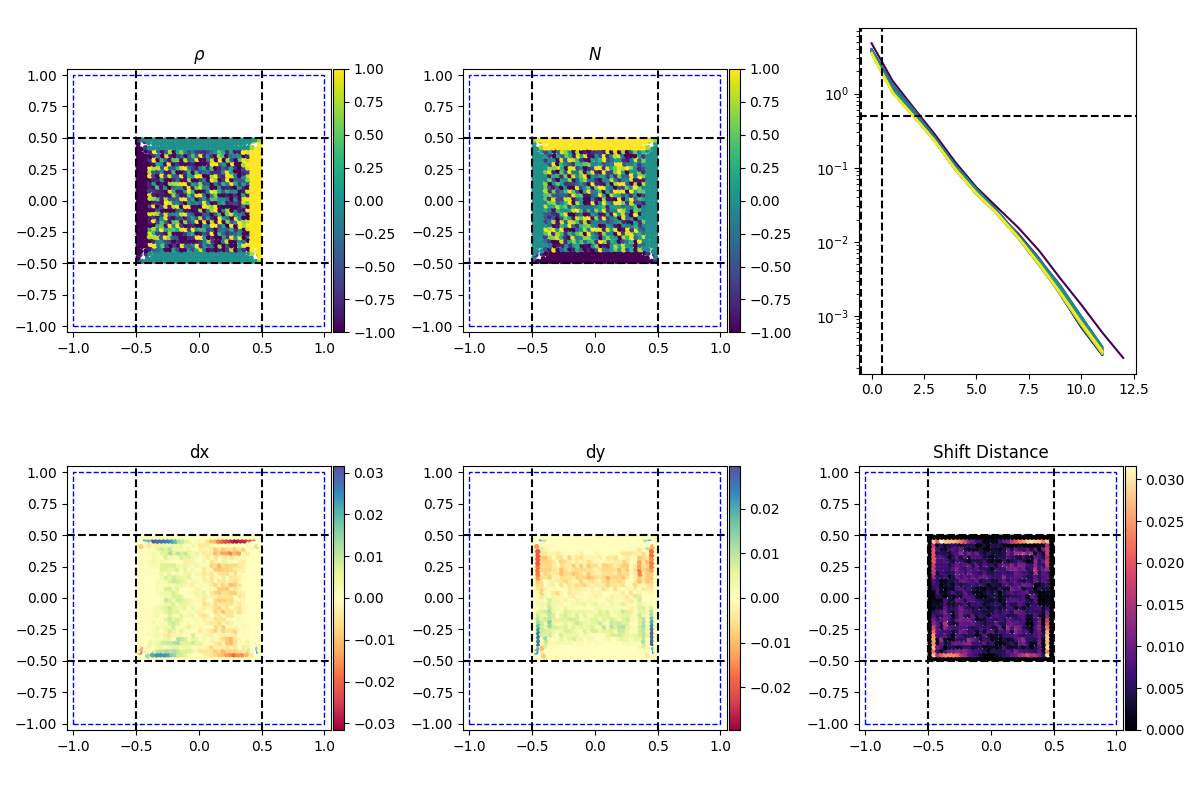

In [25]:
from diffSPH.v2.modules.shifting import solveShifting
config['shifting']['scheme'] = 'IPS'
# config['shifting']['scheme'] = 'delta'
config['shifting']['computeMach'] = False
config['shifting']['maxIterations'] = 32
config['shifting']['solver'] = 'BiCGStab'
config['shifting']['normalScheme'] = 'lambda'
config['shifting']['freeSurface'] = True
config['shifting']['useExtendedMask'] = False
config['shifting']['projectionScheme'] = 'mat'
config['shifting']['surfaceScaling'] = 1.
config['shifting']['surfaceDetection'] = 'colorGrad'
config['shifting']['summationDensity'] = False
config['shifting']['surfaceDetection'] = 'Maronne'
config['shifting']['surfaceDetection'] = 'Barcasco'
config['shifting']['initialization'] = 'zero'
config['shifting']['threshold'] = 0.05
config['shifting']['tol'] = 1e-5
config['shifting']['rtol'] = 1e-5
config['shifting']['solverThreshold'] = 1.0
config['surfaceDetection']['expansionIterations'] = 2

import matplotlib.colors as mcolors



fig, axis = plt.subplots(2, 3, figsize=(12, 8), sharex = False, sharey = False, squeeze = False)

particleState['fluid']['positions'] = initialPositions.clone() + jitter* 0.75

positions = torch.clone(particleState['fluid']['positions'])
particleState['fluid']['densities'] = torch.ones_like(particleState['fluid']['densities']) * config['fluid']['rho0']

dx, states = solveShifting(particleState, config)
particleState['fluid']['positions'] = particleState['fluid']['positions'] + dx

_, particleState['fluid']['neighborhood'] = neighborSearch(particleState['fluid'], particleState['fluid'], config)
particleState['fluid']['densities'] = sphOperationStates(particleState['fluid'],particleState['fluid'], quantities = None, operation = 'density', neighborhood = particleState['fluid']['neighborhood'])
_, particleState['fluid']['numNeighbors'] = countUniqueEntries(particleState['fluid']['neighborhood']['indices'][0], particleState['fluid']['positions'])

scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['normals'][:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['normals'][:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$N$', cmap = 'viridis', s = 8)
# scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], particleState['fluid']['freeSurface'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Surface Distance', cmap = 'magma', s = 8)

cs = [torch.hstack(s[0]).detach().cpu().numpy() for s in states]
norm = mcolors.Normalize(vmin=0, vmax=len(cs) - 1)
mappable = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
for i in range(len(cs)):
    axis[0,2].plot(cs[i], label = f'iter {i}', c = mappable.to_rgba(i))

axis[0,2].set_yscale('log')

scatterPlotSymmetric(fig, axis[1,0], particleState['fluid']['positions'], dx[:,0], config['domain']['minExtent'], config['domain']['maxExtent'], 'dx', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[1,1], particleState['fluid']['positions'], dx[:,1], config['domain']['minExtent'], config['domain']['maxExtent'], 'dy', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,2], positions, torch.linalg.norm(dx, dim = -1), config['domain']['minExtent'], config['domain']['maxExtent'], 'Shift Distance', cmap = 'magma', s = 8)

for ax in axis.flatten():
    ax.axvline(-0.5, c = 'k', ls = '--')
    ax.axvline(0.5, c = 'k', ls = '--')
    ax.axhline(-0.5, c = 'k', ls = '--')
    ax.axhline(0.5, c = 'k', ls = '--')
    
fig.tight_layout()

In [ ]:
# torch.linalg.norm(B)

tensor(8.0304)

In [23]:
numParticles = particleState['fluid']['positions'].shape[0]
if config['shifting']['freeSurface']:  
    if config['shifting']['useExtendedMask']:
        fs = particleState['fluid']['freeSurfaceMask']
    else:
        fs = particleState['fluid']['freeSurface']
    fsm = particleState['fluid']['freeSurfaceMask']

# particleState['fluid']['neighborhood'] = fluidNeighborSearch(particleState['fluid'], particleState['fluid'], config)
(i,j) = particleState['fluid']['neighborhood']['indices']
rij = particleState['fluid']['neighborhood']['distances']
xij = particleState['fluid']['neighborhood']['vectors']
hij = particleState['fluid']['neighborhood']['supports']
k = config['kernel']['function']
dim = config['domain']['dim']

K, J, H = evalKernel(rij, xij, hij, k, dim)
# if computeRho:
    # particleState['fluid']['densities'] = sphOperationFluidState(particleState, None, 'density')
    # omega =  particleState['fluidMasses'] / particleState['fluid']['densities']
# else:
omega = particleState['fluid']['areas']


J = scatter_sum(J * omega[j,None], i, dim = 0, dim_size = numParticles)
# H = H * omega[j,None,None]

h2 = particleState['fluidSupports'].repeat(2,1).T.flatten()
x0 = torch.rand(numParticles * 2).to(rij.device).type(rij.dtype) * h2 / 4 - h2 / 8
if config['shifting']['initialization'] == 'deltaPlus':
    x0 = -deltaPlusShifting(particleState, config).flatten() * 0.5
if config['shifting']['initialization'] == 'deltaMinus':
    x0 = deltaPlusShifting(particleState, config).flatten() * 0.5
if config['shifting']['initialization'] == 'zero':
    x0 = torch.zeros_like(x0)


B = torch.zeros(numParticles * 2, dtype = torch.float32, device=rij.device)
if config['shifting']['freeSurface']:

    J2 = torch.zeros(J.shape[0], 2, dtype = torch.float32, device=rij.device)
    J2[fs < 0.5, :] = J[fs < 0.5, :]

    B[::2] = J2[:,0]
    B[1::2] = J2[:,1]

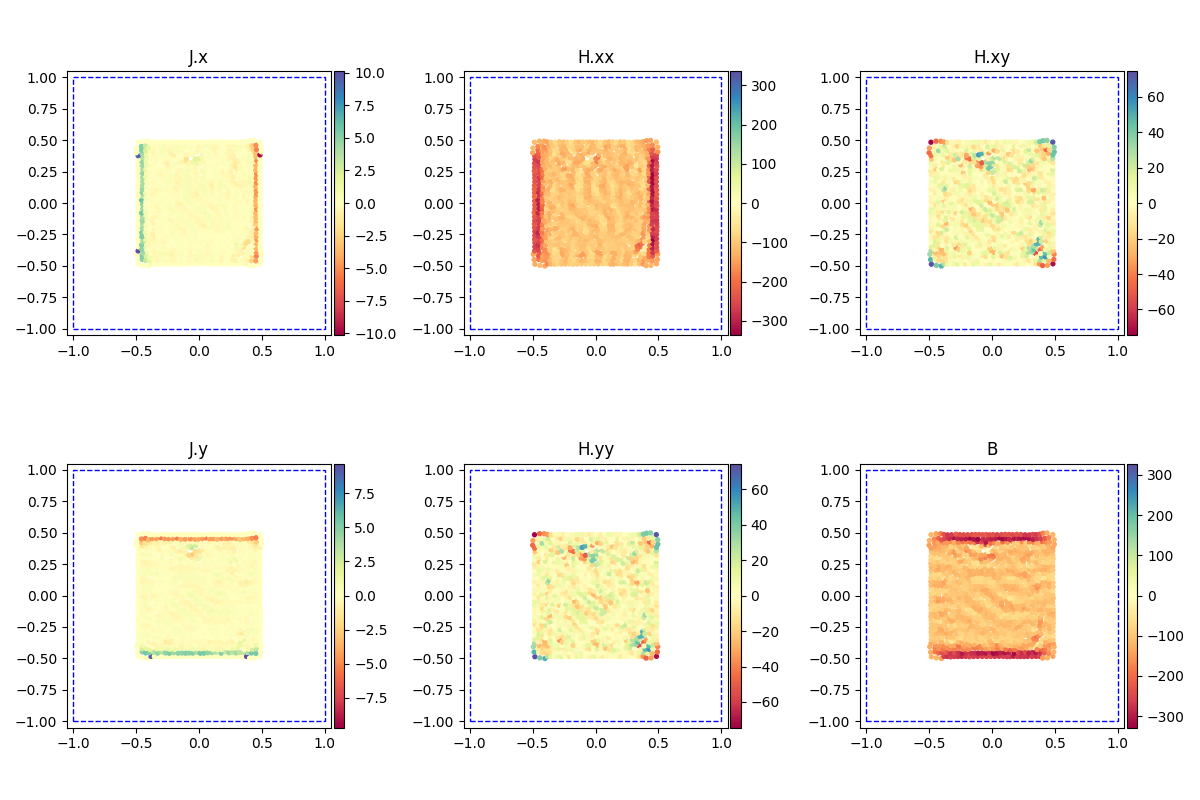

In [24]:

fig, axis = plt.subplots(2, 3, figsize=(12, 8), sharex = False, sharey = False, squeeze = False)

scatterPlotSymmetric(fig, axis[0,0], particleState['fluid']['positions'], B[::2], config['domain']['minExtent'], config['domain']['maxExtent'], 'J.x', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[1,0], particleState['fluid']['positions'], B[1::2], config['domain']['minExtent'], config['domain']['maxExtent'], 'J.y', cmap = 'Spectral', s = 8)

Hs = scatter_sum(H * omega[j,None, None], i, dim = 0, dim_size = numParticles)
scatterPlotSymmetric(fig, axis[0,1], particleState['fluid']['positions'], Hs[:,0,0], config['domain']['minExtent'], config['domain']['maxExtent'], 'H.xx', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[0,2], particleState['fluid']['positions'], Hs[:,0,1], config['domain']['minExtent'], config['domain']['maxExtent'], 'H.xy', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[1,1], particleState['fluid']['positions'], Hs[:,1,0], config['domain']['minExtent'], config['domain']['maxExtent'], 'H.yy', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[1,2], particleState['fluid']['positions'], Hs[:,1,1], config['domain']['minExtent'], config['domain']['maxExtent'], 'B', cmap = 'Spectral', s = 8)


fig.tight_layout()

In [29]:
from diffSPH.v2.modules.surfaceDetection import detectFreeSurfaceBarecasco

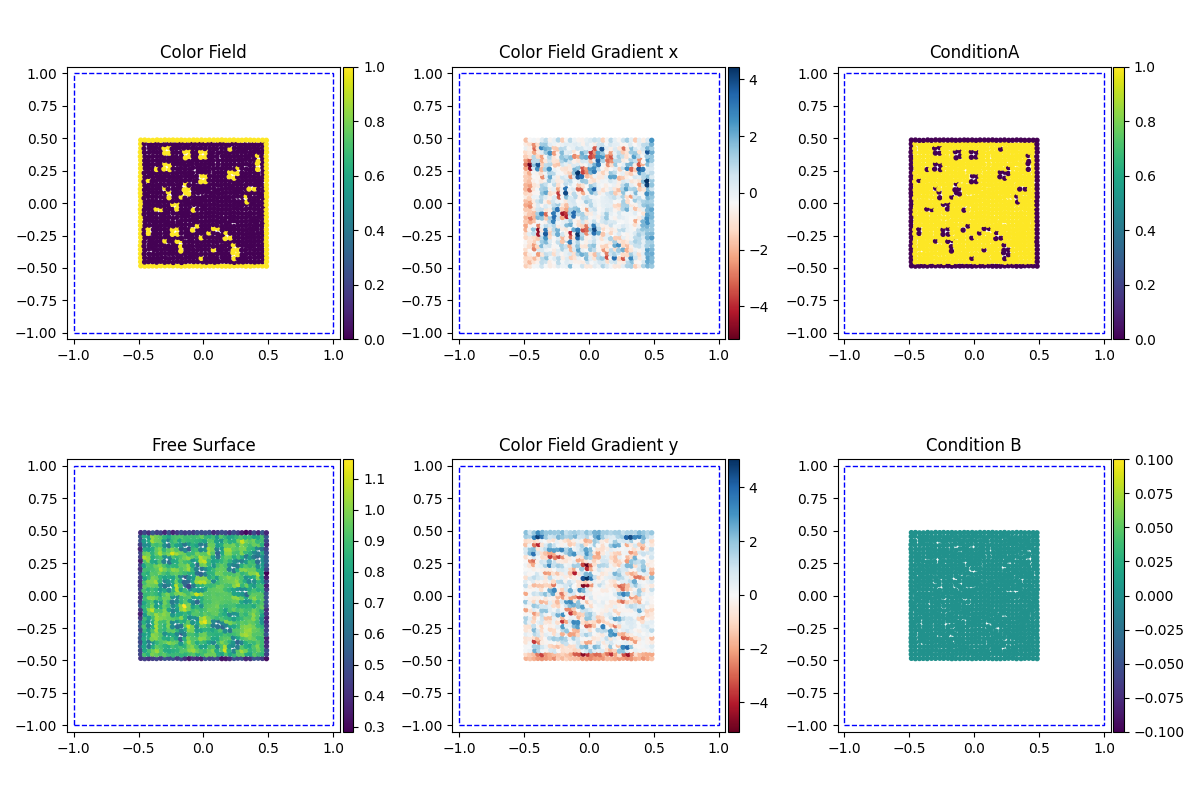

In [31]:
particleState['fluid']['densities'] = torch.ones_like(particleState['fluid']['areas']) * ( config['fluid']['rho0'])
# particleState['fluid']['densities'] = sphOperationFluidState(particleState, None, 'density')

particleState['fluid']['color'] = computeColorField(particleState, config)
# particleState['fluid']['densities'][:] = config['fluid']['rho0']
particleState['fluid']['colorGradient'] = computeColorFieldGradient(particleState, config)
config['surfaceDetection']['colorFieldGradientThreshold'] = 10.0
fs = detectFreeSurfaceColorFieldGradient(particleState, config)
particleState['fluid']['L'], normalizationMatrices, particleState['L.EVs'] = computeNormalizationMatrices(particleState, config)
particleState['fluid']['normals'], particleState['fluid']['Lambdas'] = computeNormalsMaronne(particleState, config)
particleState['fluid']['freeSurface'], cA, cB = detectFreeSurfaceMaronne(particleState, config)
particleState['fluid']['freeSurface'] = detectFreeSurfaceBarecasco(particleState, config)
particleState['fluid']['freeSurfaceMask'] = expandFreeSurfaceMask(particleState, config)
# particleState['fluid']['freeSurface'] = particleState['fluid']['Lambdas'] < 0.4

fig, axis = plt.subplots(2, 3, figsize=(12, 8), sharex = False, sharey = False, squeeze = False)

scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['freeSurface'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Color Field', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['colorGradient'][:,0], config['domain']['minExtent'], config['domain']['maxExtent'], 'Color Field Gradient x', cmap = 'RdBu', s = 8)
scatterPlot(fig, axis[1,1], particleState['fluid']['positions'], particleState['fluid']['colorGradient'][:,1], config['domain']['minExtent'], config['domain']['maxExtent'], 'Color Field Gradient y', cmap = 'RdBu', s = 8)
scatterPlot(fig, axis[1,0], particleState['fluid']['positions'], particleState['fluid']['Lambdas'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Free Surface', cmap = 'viridis', s = 8)

scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], cA, config['domain']['minExtent'], config['domain']['maxExtent'], 'ConditionA', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[1,2], particleState['fluid']['positions'], cB, config['domain']['minExtent'], config['domain']['maxExtent'], 'Condition B', cmap = 'viridis', s = 8)

fig.tight_layout()

In [32]:
torch.min(particleState['L.EVs'], dim = 0)

torch.return_types.min(
values=tensor([0.3945, 0.2283]),
indices=tensor([31,  0]))

In [142]:
particleState['fluid']['densities']

tensor([1.9531, 1.9531, 1.9531,  ..., 1.9531, 1.9531, 1.9531])

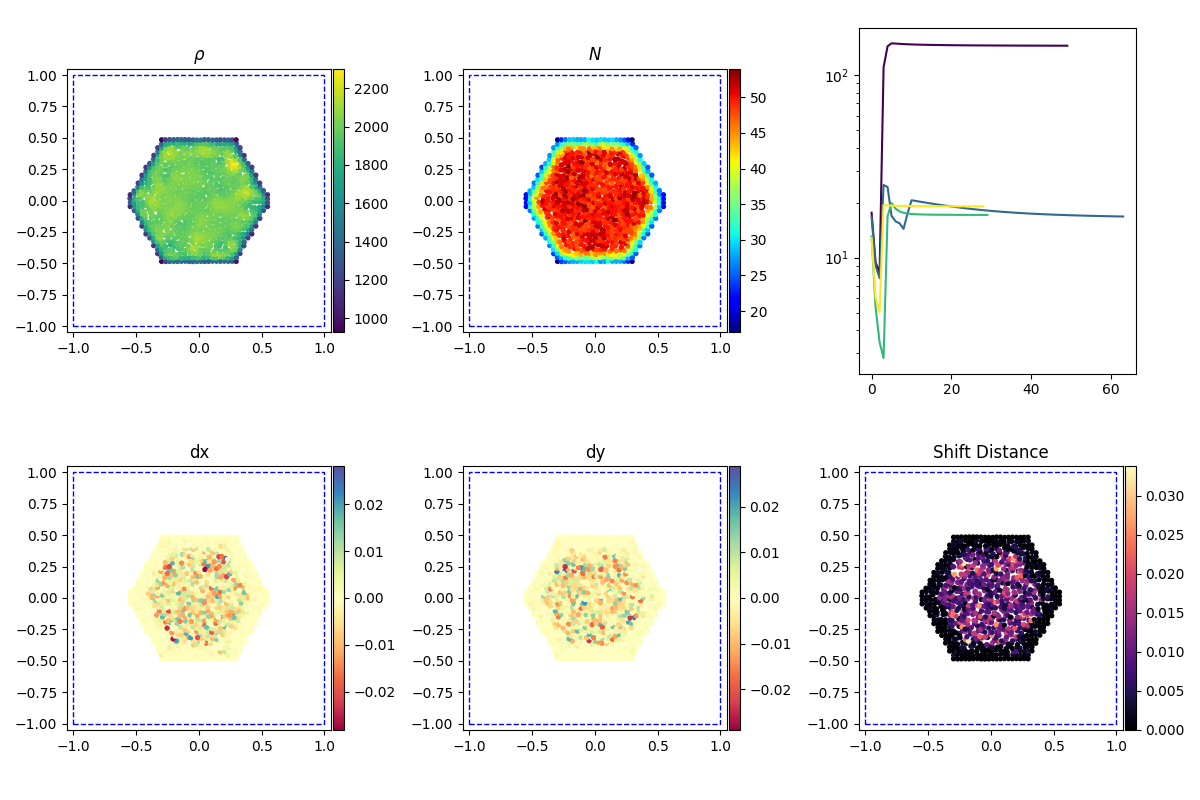

In [22]:
config['shifting']['scheme'] = 'IPS'
config['shifting']['maxIterations'] = 4
config['shifting']['solver'] = 'BiCGStab'
config['shifting']['freeSurface'] = True
config['shifting']['useExtendedMask'] = False

fig, axis = plt.subplots(2, 3, figsize=(12, 8), sharex = False, sharey = False, squeeze = False)

particleState['fluid']['positions'] = initialPositions.clone() + jitter

positions = torch.clone(particleState['fluid']['positions'])

dx, states = solveShifting(particleState, config)
particleState['fluid']['positions'] = particleState['fluid']['positions'] + dx

particleState['fluid']['neighborhood'] = fluidNeighborSearch(particleState['fluid'], particleState['fluid'], config)
particleState['fluid']['densities'] = sphOperationFluidState(particleState, None, 'density')
_, particleState['fluid']['numNeighbors'] = countUniqueEntries(particleState['fluid']['neighborhood']['indices'][0], particleState['fluid']['positions'])

scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['densities'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['numNeighbors'], config['domain']['minExtent'], config['domain']['maxExtent'], '$N$', cmap = 'jet', s = 8)
# scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], particleState['fluid']['distances'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Surface Distance', cmap = 'magma', s = 8)

cs = [torch.hstack(s[0]).detach().cpu().numpy() for s in states]
norm = mcolors.Normalize(vmin=0, vmax=len(cs) - 1)
mappable = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
for i in range(len(cs)):
    axis[0,2].plot(cs[i], label = f'iter {i}', c = mappable.to_rgba(i))

axis[0,2].set_yscale('log')

scatterPlotSymmetric(fig, axis[1,0], particleState['fluid']['positions'], dx[:,0], config['domain']['minExtent'], config['domain']['maxExtent'], 'dx', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[1,1], particleState['fluid']['positions'], dx[:,1], config['domain']['minExtent'], config['domain']['maxExtent'], 'dy', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,2], positions, torch.linalg.norm(dx, dim = -1), config['domain']['minExtent'], config['domain']['maxExtent'], 'Shift Distance', cmap = 'magma', s = 8)

fig.tight_layout()

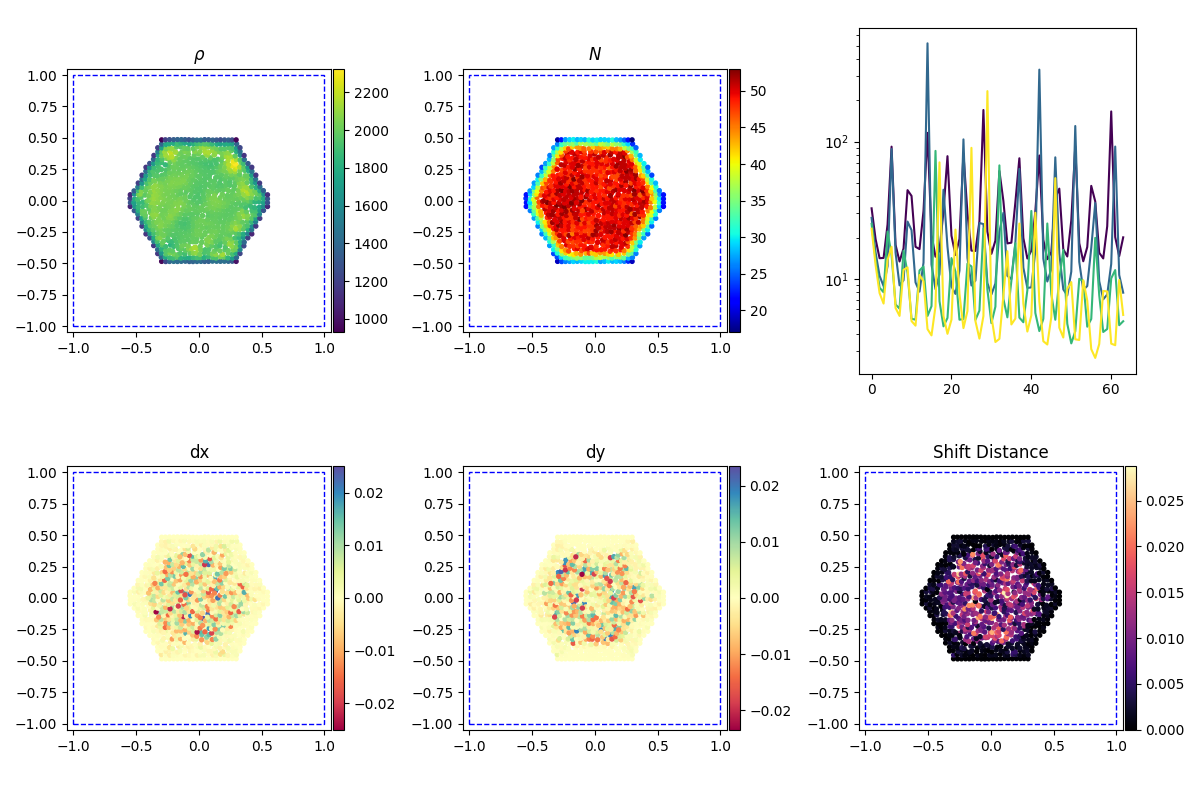

In [24]:
config['shifting']['scheme'] = 'IPS'
config['shifting']['maxIterations'] = 4
config['shifting']['solver'] = 'LinearCG'
config['shifting']['freeSurface'] = True
config['shifting']['useExtendedMask'] = False

fig, axis = plt.subplots(2, 3, figsize=(12, 8), sharex = False, sharey = False, squeeze = False)

particleState['fluid']['positions'] = initialPositions.clone() + jitter

positions = torch.clone(particleState['fluid']['positions'])

dx, states = solveShifting(particleState, config)
particleState['fluid']['positions'] = particleState['fluid']['positions'] + dx

particleState['fluid']['neighborhood'] = fluidNeighborSearch(particleState['fluid'], particleState['fluid'], config)
particleState['fluid']['densities'] = sphOperationFluidState(particleState, None, 'density')
_, particleState['fluid']['numNeighbors'] = countUniqueEntries(particleState['fluid']['neighborhood']['indices'][0], particleState['fluid']['positions'])

scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['densities'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['numNeighbors'], config['domain']['minExtent'], config['domain']['maxExtent'], '$N$', cmap = 'jet', s = 8)
# scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], particleState['fluid']['distances'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Surface Distance', cmap = 'magma', s = 8)

cs = [torch.hstack(s[0]).detach().cpu().numpy() for s in states]
norm = mcolors.Normalize(vmin=0, vmax=len(cs) - 1)
mappable = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
for i in range(len(cs)):
    axis[0,2].plot(cs[i], label = f'iter {i}', c = mappable.to_rgba(i))

axis[0,2].set_yscale('log')

scatterPlotSymmetric(fig, axis[1,0], particleState['fluid']['positions'], dx[:,0], config['domain']['minExtent'], config['domain']['maxExtent'], 'dx', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[1,1], particleState['fluid']['positions'], dx[:,1], config['domain']['minExtent'], config['domain']['maxExtent'], 'dy', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,2], positions, torch.linalg.norm(dx, dim = -1), config['domain']['minExtent'], config['domain']['maxExtent'], 'Shift Distance', cmap = 'magma', s = 8)

fig.tight_layout()

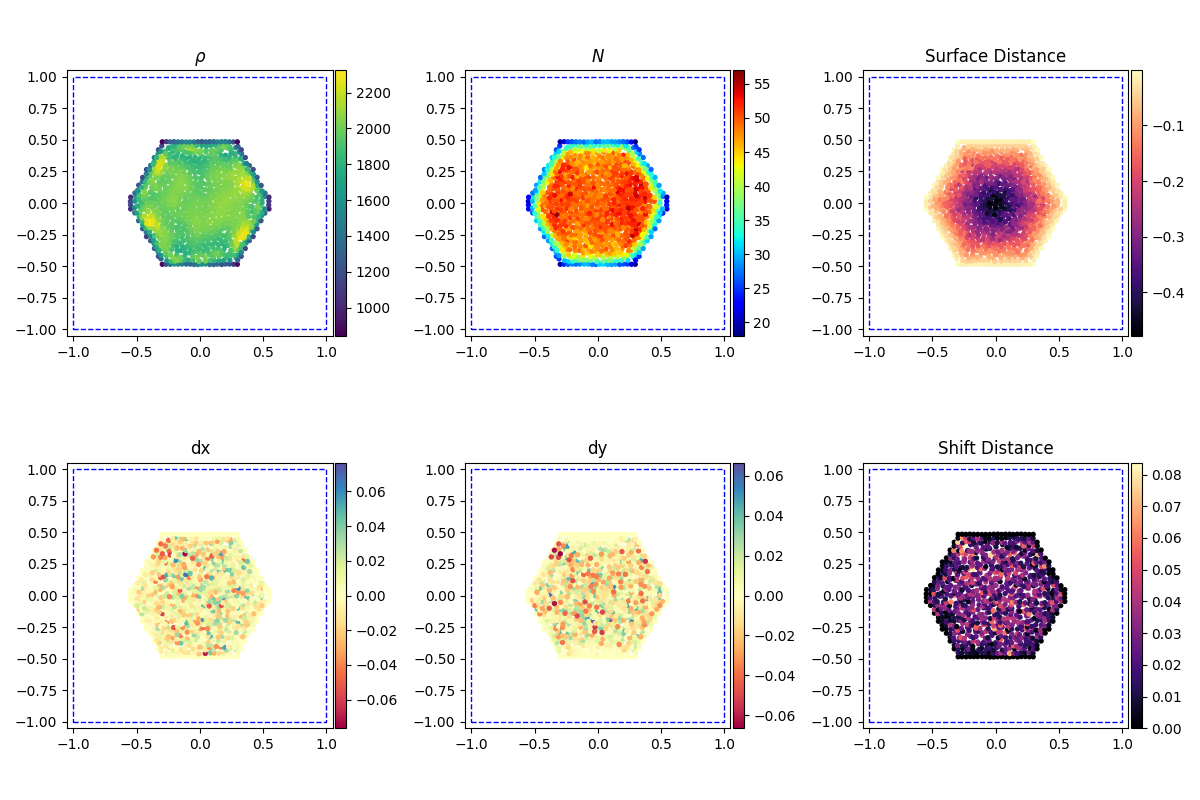

In [ ]:
config['shifting']['scheme'] = 'deltaPlus'
config['shifting']['freeSurface'] = True
config['shifting']['useExtendedMask'] = False

fig, axis = plt.subplots(2, 3, figsize=(12, 8), sharex = False, sharey = False, squeeze = False)

particleState['fluid']['positions'] = initialPositions.clone() + jitter

positions = torch.clone(particleState['fluid']['positions'])

dx = solveShifting(particleState, config)
particleState['fluid']['positions'] = particleState['fluid']['positions'] + dx

particleState['fluid']['neighborhood'] = fluidNeighborSearch(particleState['fluid'], particleState['fluid'], config)
particleState['fluid']['densities'] = sphOperationFluidState(particleState, None, 'density')
_, particleState['fluid']['numNeighbors'] = countUniqueEntries(particleState['fluid']['neighborhood']['indices'][0], particleState['fluid']['positions'])

scatterPlot(fig, axis[0,0], particleState['fluid']['positions'], particleState['fluid']['densities'], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\rho$', cmap = 'viridis', s = 8)
scatterPlot(fig, axis[0,1], particleState['fluid']['positions'], particleState['fluid']['numNeighbors'], config['domain']['minExtent'], config['domain']['maxExtent'], '$N$', cmap = 'jet', s = 8)
scatterPlot(fig, axis[0,2], particleState['fluid']['positions'], particleState['fluid']['distances'], config['domain']['minExtent'], config['domain']['maxExtent'], 'Surface Distance', cmap = 'magma', s = 8)

scatterPlotSymmetric(fig, axis[1,0], particleState['fluid']['positions'], dx[:,0], config['domain']['minExtent'], config['domain']['maxExtent'], 'dx', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[1,1], particleState['fluid']['positions'], dx[:,1], config['domain']['minExtent'], config['domain']['maxExtent'], 'dy', cmap = 'Spectral', s = 8)
scatterPlot(fig, axis[1,2], positions, torch.linalg.norm(dx, dim = -1), config['domain']['minExtent'], config['domain']['maxExtent'], 'Shift Distance', cmap = 'magma', s = 8)

fig.tight_layout()

In [ ]:
config['shifting']['scheme'] = 'IPS'
config['shifting']['freeSurface'] = True
config['shifting']['useExtendedMask'] = False

particleState['fluid']['positions'] = initialPositions.clone() + jitter

positions = torch.clone(particleState['fluid']['positions'])

# dx = solveShifting(particleState, config)
# particleState['fluid']['positions'] = particleState['fluid']['positions'] + dx

from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
    for i in range(1):
        with record_function("full Timestep"): 
            dx = solveShifting(particleState, config)
        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

prof.export_chrome_trace("traceGPU.json")

STAGE:2024-02-26 13:39:25 1339437:1339437 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
[W CPUAllocator.cpp:235] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event
STAGE:2024-02-26 13:39:29 1339437:1339437 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-02-26 13:39:29 1339437:1339437 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


-----------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            full Timestep         3.11%      91.375ms        97.57%        2.863s        2.863s       1.71 Mb    -885.58 Mb             1  
                                 LinearCG         4.35%     127.768ms        60.14%        1.765s      55.154ms     222.00 Kb    -524.71 Mb            32  
                              aten::index        28.63%     840.040ms        29.48%     864.960ms     155.345us    -136.00 Mb    -163.93 Mb          5568  
                       aten::scatter_add_        21.26%     623.